In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, SVHN
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, Grayscale
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda:1'

In [3]:
def weights_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        layer.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        layer.weight.data.normal_(1.0, 0.02)
        layer.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        size = layer.weight.size()
        layer.weight.data.normal_(0.0, 0.1)
        layer.bias.data.fill_(0)

In [4]:
seed = 0
width = 32
channels = 3
batch_size = 100
epochs = 10

filters = 64
embedding_dim = 128
latent_dim = 512
lr = 0.0005
beta1 = 0.8

adv_weight = 0.1
alpha = 0.3

In [5]:
_ = torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
transform = Compose([Resize(width), Grayscale(channels), ToTensor(), Normalize([0.5]*channels, [0.5]*channels)])

In [7]:
source_train = SVHN(root='../datasets/', transform=transform, split='train')
source_validation = SVHN(root='../datasets/', transform=transform, split='test')
target_train = MNIST(root='../datasets/', train=True, transform=transform)

nclasses = len(set(source_train.labels))

In [8]:
# Encoder
F = nn.Sequential(
    nn.Conv2d(channels, filters, 5, 1, 0),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(filters, filters, 5, 1, 0),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(filters, embedding_dim, 5, 1,0),
    nn.ReLU(inplace=True)
).apply(weights_init).to(device)

In [9]:
# Generator
G = nn.Sequential(
    nn.ConvTranspose2d(latent_dim + embedding_dim + nclasses+1, filters*8, 2, 1, 0, bias=False),
    nn.BatchNorm2d(filters*8),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters*8, filters*4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters*4, filters*2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters*2, filters, 4, 2, 1, bias=False),
    nn.BatchNorm2d(filters),
    nn.ReLU(True),

    nn.ConvTranspose2d(filters, 3, 4, 2, 1, bias=False),
    nn.Tanh()
).apply(weights_init).to(device)

In [10]:
# ACGAN output
class ACModule(nn.Module):
    def __init__(self, filters, nclasses):
        super(ACModule, self).__init__()
        self.filters = filters
        self.classifier_c = nn.Sequential(nn.Linear(filters*2, nclasses))              
        self.classifier_s = nn.Sequential(
            nn.Linear(filters*2, 1), 
            nn.Sigmoid()
        )
    def forward(self, x):
        real_prob = self.classifier_s(x.view(-1, self.filters*2)).view(-1)
        class_prob = self.classifier_c(x.view(-1, self.filters*2))
        return real_prob, class_prob

In [11]:
# Discriminator
D = nn.Sequential(
    nn.Conv2d(3, filters, 3, 1, 1),            
    nn.BatchNorm2d(filters),
    nn.LeakyReLU(0.2, inplace=True),
    nn.MaxPool2d(2,2),

    nn.Conv2d(filters, filters*2, 3, 1, 1),         
    nn.BatchNorm2d(filters*2),
    nn.LeakyReLU(0.2, inplace=True),
    nn.MaxPool2d(2,2),
    

    nn.Conv2d(filters*2, filters*4, 3, 1, 1),           
    nn.BatchNorm2d(filters*4),
    nn.LeakyReLU(0.2, inplace=True),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(filters*4, filters*2, 3, 1, 1),           
    nn.BatchNorm2d(filters*2),
    nn.LeakyReLU(0.2, inplace=True),
    nn.MaxPool2d(4,4),
    ACModule(filters, nclasses)
).apply(weights_init).to(device)

In [12]:
# Classifier
C = nn.Sequential(
    nn.Linear(2*filters, 2*filters),
    nn.ReLU(inplace=True),
    nn.Linear(2*filters, nclasses),      
).apply(weights_init).to(device)

In [13]:
# AC Loss Functions
criterion_clf = nn.CrossEntropyLoss().to(device)
criterion_dis = nn.BCELoss().to(device)

In [14]:
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerF = optim.Adam(F.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerC = optim.Adam(C.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
real_label_val = 1
fake_label_val = 0

In [16]:
real_labels = torch.FloatTensor(batch_size).fill_(real_label_val).to(device)
fake_labels = torch.FloatTensor(batch_size).fill_(fake_label_val).to(device)

In [17]:
source_train_loader = DataLoader(source_train, batch_size=batch_size, shuffle=True, drop_last=True)
source_validation_loader = DataLoader(source_validation, batch_size=batch_size, shuffle=True, drop_last=False)
target_train_loader = DataLoader(target_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [18]:
losses = {
    'D': [],
    'G': [],
    'F': [],
    'C': []
}
accuracy = []

In [19]:
D.train()
G.train()
F.train()
C.train()
for _ in range(epochs):
    F.train()
    C.train()
    for it, (source_batch, target_batch) in enumerate(zip(source_train_loader, target_train_loader)):
        '''
        Pre-processing
        '''
        source_images, source_labels = map(lambda v: v.to(device), source_batch)   
        target_images, target_labels = map(lambda v: v.to(device), target_batch)
        
        # compute one-hot vectors
        source_labels_oh = nn.functional.one_hot(source_labels, nclasses+1).float().to(device)
        target_labels_oh = source_labels_oh.scatter(1, torch.LongTensor(batch_size, 1).fill_(nclasses).to(device), 1)
        
        # sample latent noise batch
        latent_batch = torch.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1).to(device)
        
        # compute emeddings from source images
        source_embedding = F(source_images).view(batch_size, -1)
        source_embedding_cat = torch.cat((source_labels_oh, source_embedding), 1)
        source_embedding_cat = source_embedding_cat.view(batch_size, -1, 1, 1)
        source_embedding_cat = torch.cat((source_embedding_cat, latent_batch), 1)
        
        # compute emeddings from target images
        target_embedding = F(target_images).view(batch_size, -1)
        target_embedding_cat = torch.cat((target_labels_oh, target_embedding), 1)
        target_embedding_cat = target_embedding_cat.view(batch_size, -1, 1, 1)
        target_embedding_cat = torch.cat((target_embedding_cat, latent_batch), 1)
        
        # generate samples from concatentated embeddings
        source_generated_samples = G(source_embedding_cat)
        target_generated_samples = G(target_embedding_cat)
        
        '''
        Update D
        '''
        D.zero_grad()

        # compute discriminator losses on real source images
        source_real_dis, source_real_clf = D(source_images)
        source_D_dis_loss_real = criterion_dis(source_real_dis, real_labels)
        source_D_clf_loss_real = criterion_clf(source_real_clf, source_labels)
        
        # compute discriminator losses on fake source images
        source_fake_dis, source_fake_clf = D(source_generated_samples)
        source_D_dis_loss_fake = criterion_dis(source_fake_dis, fake_labels)
        
        # compute discriminator losses on fake target images
        target_fake_dis, target_fake_clf = D(target_generated_samples)
        target_D_d_loss_fake = criterion_dis(target_fake_dis, fake_labels)
        
        # perform D optimization step
        D_loss = source_D_dis_loss_real + source_D_clf_loss_real + source_D_dis_loss_fake + target_D_d_loss_fake
        D_loss.backward(retain_graph=True)
        optimizerD.step()
    
        '''
        Update G
        '''
        G.zero_grad()
        
        # compute generator losses
        source_fake_dis, source_fake_clf = D(source_generated_samples)
        source_D_dis_loss_fake = criterion_dis(source_fake_dis, real_labels)
        source_D_clf_loss_fake = criterion_clf(source_fake_clf, source_labels)
        
        # perform G optimization step
        G_loss = source_D_dis_loss_fake + source_D_clf_loss_fake
        G_loss.backward(retain_graph=True)
        optimizerG.step()
        
        '''
        Update C
        '''
        C.zero_grad()
        
        # compute classifier losses
        source_clf = C(source_embedding)
        C_loss = criterion_clf(source_clf, source_labels)
        
        # perform G optimization step
        C_loss.backward(retain_graph=True)
        optimizerC.step()
        
        '''
        Update F
        '''
        F.zero_grad()
        
        # compute encoder loss from updated classifier
        source_clf = C(source_embedding)
        C_loss = criterion_clf(source_clf, source_labels)
        
        # re-generate samples using updated generator
        source_generated_samples = G(source_embedding_cat)
        target_generated_samples = G(target_embedding_cat)

        # compute encoder loss from GAN
        source_fake_dis, source_fake_clf = D(source_generated_samples)
        source_D_clf_loss_fake = criterion_clf(source_fake_clf, source_labels)
        
        target_fake_dis, target_fake_clf = D(target_generated_samples)
        target_D_dis_loss_fake = criterion_dis(target_fake_dis, real_labels)
        
        # perform F optimization step
        F_loss = C_loss + adv_weight * (source_D_clf_loss_fake + alpha * target_D_dis_loss_fake)
        F_loss.backward(retain_graph=True)
        optimizerF.step()
        
        '''
        Bookkeeping
        '''
        losses['D'].append(D_loss.item())
        losses['G'].append(G_loss.item())
        losses['F'].append(F_loss.item())
        losses['C'].append(C_loss.item())
        
    F.eval()
    C.eval()
    correct, total = [], []
    for it, (images, labels) in enumerate(source_validation_loader):
        images, labels = images.to(device), labels.to(device)
        embeddings = F(images).squeeze()
        predictions = C(embeddings)
        correct.append(torch.sum(torch.argmax(predictions, 1) == labels).item())
        total.append(len(images))
    accuracy.append(sum(correct)/sum(total))

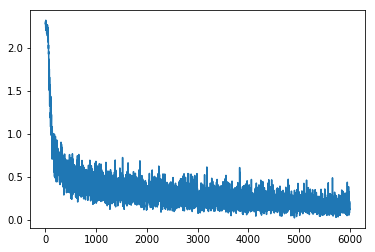

In [20]:
plt.plot(losses['C'])
plt.show()

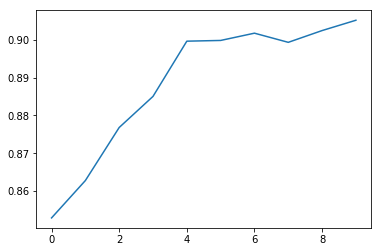

In [21]:
plt.plot(accuracy)
plt.show()